# Physics-Informed Neural Networks

Original [paper](https://www.sciencedirect.com/science/article/pii/S0021999118307125) by M.Raissi et al. 

In complex physical, biological or engineering systems, obtaining data is sometimes unachievable. State of the art machine learning techniques cannot provide any guarantee of convergence given the lack of training data. 

**Traditional physics model** creation is a task of a domain expert, who parametrises physics models to best fit a system of interest. For example, creating a model of aircraft dynamics using equations of drag, lift, gravity, thrust, etc., and parametrising the model to attempt to closely match the model to a specific aircraft.

However, sometimes physical systems are hard to parametrise and there does not exist a closed form solution. 

In [1]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 8})

import jax.numpy as jnp
from jax import value_and_grad, jit, random, vmap
import optax

from tqdm.contrib import tzip

KEY = random.PRNGKey(1)

/Users/JDDJ/local/conda/envs/cs182_pinn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import Schrodinger Data

In [2]:
data = scipy.io.loadmat("original_paper/Data/NLS.mat")

# Global variables
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])
N0 = 50
N_b = 50
N_f = 20000

# Original data (including training and validation)
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
u = np.real(data['uu'])
v = np.imag(data['uu'])
h = np.sqrt(u**2 + v**2)

# Initial Condition Data (N = 50)
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
t0 = np.zeros(x0.shape)
u0 = u[idx_x,0:1]
v0 = v[idx_x,0:1]
X0 = np.concatenate([x0, t0], axis=1)
Y0 = np.concatenate([u0, v0], axis=1)

# Boundary Condition Data (N = 50 + 50)
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]
t_ub = t_lb = tb
X_ub = np.concatenate([np.zeros(tb.shape) + ub[0], t_ub], axis=1)
X_lb = np.concatenate([np.zeros(tb.shape) + lb[0], t_lb], axis=1)
Xb = np.concatenate([X_ub, X_lb])
u_lb = u[0, idx_t][..., None]
u_ub = u_lb
v_lb = v[0, idx_t][..., None]
v_ub = v_lb
Y_ub = np.concatenate([u_ub, v_ub], axis=1)
Y_lb = np.concatenate([u_lb, v_lb], axis=1)
Yb = np.concatenate([Y_ub, Y_lb])

# Training data (N = 50 + (50 + 50))
X = np.concatenate([X0, Xb])
Y = np.concatenate([Y0, Yb])

In [3]:
print(f"Initial condition training data. X0: {X0.shape}, Y0: {Y0.shape}")
print(f"Boundary condition training data. Xb: {Xb.shape}, Yb: {Yb.shape}")
print(f"Total training data. X: {X.shape}, Y: {Y.shape}")

Initial condition training data. X0: (50, 2), Y0: (50, 2)
Boundary condition training data. Xb: (100, 2), Yb: (100, 2)
Total training data. X: (150, 2), Y: (150, 2)


### Visualizing our full data

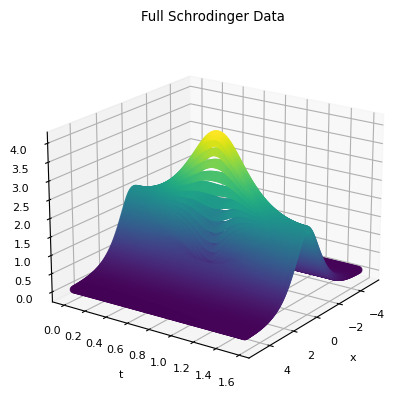

In [4]:
t_grid, x_grid = np.meshgrid(t,x)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(20, 35)
ax.scatter(x_grid, t_grid, h, c=h, cmap='viridis')
ax.set(xlabel="x", ylabel="t", title="Full Schrodinger Data");

### Visualizing our training data on initial condition (t=0)

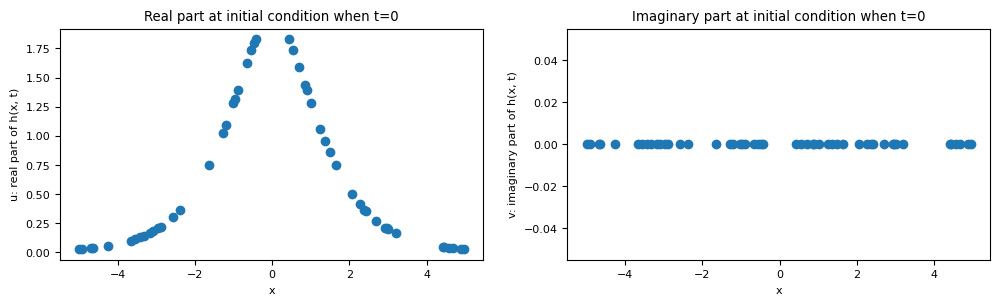

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].scatter(X0[:, 0], Y0[:, 0])
axs[1].scatter(X0[:, 0], Y0[:, 1])
axs[0].set(xlabel="x", ylabel="u: real part of h(x, t)", title="Real part at initial condition when t=0")
axs[1].set(xlabel="x", ylabel="v: imaginary part of h(x, t)", title="Imaginary part at initial condition when t=0");

### Visualizing our training data on boundary condition (x=-5 and x=5)

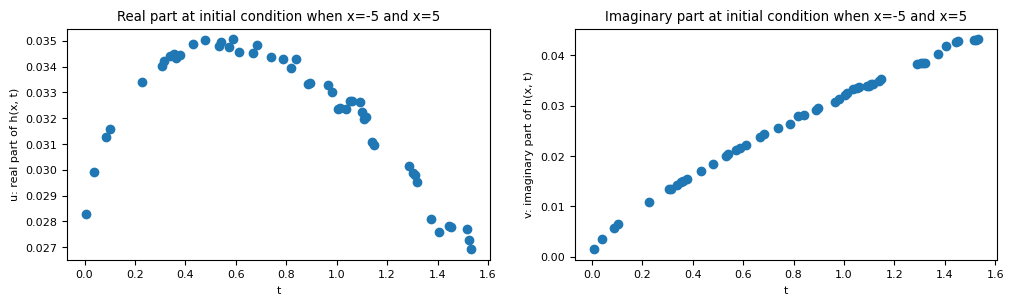

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].scatter(Xb[:50, 1], Yb[:50, 0])
axs[1].scatter(Xb[:50, 1], Yb[:50, 1])
axs[0].set(xlabel="t", ylabel="u: real part of h(x, t)", title="Real part at initial condition when x=-5 and x=5")
axs[1].set(xlabel="t", ylabel="v: imaginary part of h(x, t)", title="Imaginary part at initial condition when x=-5 and x=5");

## Vanilla MLP

First implement `init_params` and `forward`

In [7]:
def init_params(layers, key=KEY):
    '''
    Initialize parameters in the MLP. Weights are initialized
    using Xavier initialization, while biases are zero initialized.

    Returns
    - params: the initialized parameters
    '''
    def xavier_init(input_dim, output_dim, key=key):
        '''Use Xavier initialization for weights of a single layer'''
        std_dev = jnp.sqrt(2/(input_dim + output_dim)) # compute standard deviation for xavier init
        w = std_dev * random.normal(key, (input_dim, output_dim)) # initialize the weights
        return w

    params = []

    for l in range(len(layers) - 1):
        w = xavier_init(layers[l], layers[l+1]) # xavier initialize the weight
        b = jnp.zeros(layers[l+1]) # zero initialize the bias
        params.append((w, b)) # append weight and bias for this layer to params
    
    return params


def vanilla_forward(params, x):
    '''
    Forward pass through the vanilla MLP. In PINN, the nonlinearity are
    applied using tanh.

    Arguments
    - params: weights and biases for all layers of the vanilla MLP
    - x: input to the vanilla MLP

    Returns
    - out: output of the vanilla MLP
    '''
    activations = x
    for w, b in params[:-1]:
        out = jnp.dot(activations, w) + b # Perform linear operation
        activations = jnp.tanh(out) # apply tanh activation
    
    final_w, final_b = params[-1]
    out = jnp.dot(activations, final_w) + final_b # Do not apply nonlinearity to last layer
    return out

vanilla_batched_forward = vmap(vanilla_forward, in_axes=(None, 0))

Test implementation for `init_param` and `forward`.

In [8]:
layers = [2, 10, 1]
x = random.uniform(KEY, (5, 2))
out = vanilla_batched_forward(init_params(layers), x)
expected = jnp.array([[-0.05742961],
                      [-0.08960884],
                      [-0.04750253],
                      [-0.17843515],
                      [-0.09102767]])
assert jnp.allclose(out, expected)

Now implement `mseloss` and `update`

In [9]:
def vanilla_mseloss(params, x, y):
    pred = vanilla_batched_forward(params, x)
    return jnp.mean(jnp.square(pred - y))

def vanilla_fit(params, optimizer, X, Y):
    opt_state = optimizer.init(params)

    @jit
    def step(params, opt_state, x, y):
        loss_value, grads = value_and_grad(vanilla_mseloss)(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    train_losses = [0]

    for epoch in range(5):
        for (x, y) in tzip(X, Y):
            params, opt_state, loss_value = step(params, opt_state, x, y)
            train_losses.append(loss_value)
        print(f'epoch {epoch}, average loss: {jnp.mean(loss_value)}')

    # plt.plot(train_losses)

    return params

In [10]:
layers = [2, 100, 100, 100, 100, 2]

optimizer = optax.adam(learning_rate=5e-4)
trained_params = vanilla_fit(init_params(layers), optimizer, X, Y)

100%|██████████| 150/150 [00:01<00:00, 87.86it/s] 


epoch 0, average loss: 0.00045584101462736726


100%|██████████| 150/150 [00:00<00:00, 1549.25it/s]


epoch 1, average loss: 0.0004946313565596938


100%|██████████| 150/150 [00:00<00:00, 2357.85it/s]


epoch 2, average loss: 0.0006312837940640748


100%|██████████| 150/150 [00:00<00:00, 2297.38it/s]


epoch 3, average loss: 0.000534439051989466


100%|██████████| 150/150 [00:00<00:00, 2696.53it/s]

epoch 4, average loss: 0.00032563996501266956


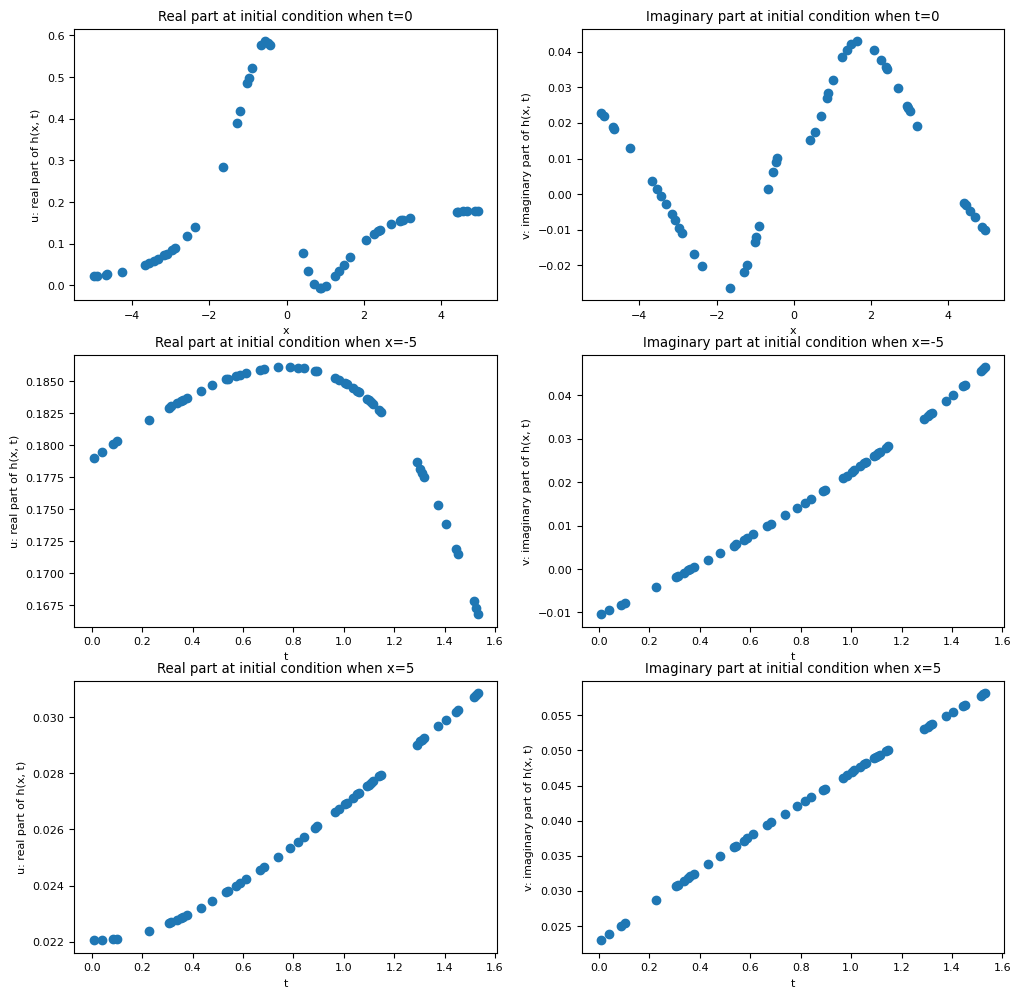

In [11]:
pred = vanilla_batched_forward(trained_params, X)

fig, axs = plt.subplots(3,2, figsize=(12, 12))
axs[0,0].scatter(X[:50, 0], pred[:50, 0])
axs[0,1].scatter(X[:50, 0], pred[:50, 1])
axs[0,0].set(xlabel="x", ylabel="u: real part of h(x, t)", title="Real part at initial condition when t=0")
axs[0,1].set(xlabel="x", ylabel="v: imaginary part of h(x, t)", title="Imaginary part at initial condition when t=0")
axs[1,0].scatter(X[50:100, 1], pred[50:100, 0])
axs[1,1].scatter(X[50:100, 1], pred[50:100, 1])
axs[1,0].set(xlabel="t", ylabel="u: real part of h(x, t)", title="Real part at initial condition when x=-5")
axs[1,1].set(xlabel="t", ylabel="v: imaginary part of h(x, t)", title="Imaginary part at initial condition when x=-5")
axs[2,0].scatter(X[100:, 1], pred[100:, 0])
axs[2,1].scatter(X[100:, 1], pred[100:, 1])
axs[2,0].set(xlabel="t", ylabel="u: real part of h(x, t)", title="Real part at initial condition when x=5")
axs[2,1].set(xlabel="t", ylabel="v: imaginary part of h(x, t)", title="Imaginary part at initial condition when x=5");

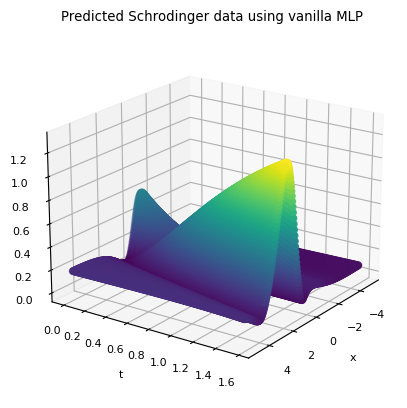

In [12]:
t_all = t_grid.flatten()[..., None]
x_all = x_grid.flatten()[..., None]
X_all = np.concatenate([x_all, t_all], axis=1)

pred = vanilla_batched_forward(trained_params, X_all)
pred_h = np.sqrt(pred[:,0]**2 + pred[:,1]**2)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(20, 35)
ax.scatter(x_all, t_all, pred_h, c=pred_h, cmap='viridis')
ax.set(xlabel="x", ylabel="t", title="Predicted Schrodinger data using vanilla MLP");